# Imports

In [3]:
%matplotlib inline
#%matplotlib notebook

#Basic stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Test / train data
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

# ML Metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, zero_one_loss

# Initialize tqdm progress bar
from tqdm import tqdm, tnrange, tqdm_notebook
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)

In [4]:
from utils import train_test_split_data, evaluate_model, \
                  plot_precision_recall, plot_precision_recall_vs_thresholds, \
                  plot_roc_curve

# Functions

# Data

In [5]:
active = pd.read_pickle("./active.pkl.bz2")
inactive = pd.read_pickle("./inactive.pkl.bz2")
inconclusive = pd.read_pickle("./inconclusive.pkl.bz2")

# Results *should* be:
# active       =  (829, 10)
# inactive     =  (50000, 7)
# Inconclusive =  (1526, 6)

print("active       = ", active.shape)
print("inactive     = ", inactive.shape)
print("Inconclusive = ", inconclusive.shape)

active       =  (829, 10)
inactive     =  (50000, 7)
Inconclusive =  (1526, 6)


In [4]:
# Add active bit for classification tasks
active['ActiveBit']   = True
inactive['ActiveBit'] = False

# Prepare a DataFrame with only the data we need
columns = ['PUBCHEM_SID', 'RDKit Fingerprints', 'Morgan Fingerprints','ActiveBit']
data = pd.concat([active.filter(columns,axis=1),inactive],
                 axis=0,join='inner', ignore_index=True)

In [5]:
# Use only Morgan Fingerprints
X = np.array(list(data['Morgan Fingerprints'])).astype(int)
y = data['ActiveBit'].values

In [7]:
# Split the data into train & test sets
X_train, X_test, y_train, y_test = train_test_split_data(X, y, rate_inactives=0.9)

X_train:  7461 	y_train:  7461 	( 746 actives and 6715 inactives)
X_test:   829  	y_test:   829  	( 83 actives and 746 inactives)


In [131]:
# Dataframe to store the results
results = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-score', 'Zero-One Loss', 'ROC AUC'])

# Linear Regression Models

In [10]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier

## Ridge Classifier

In [128]:
alphas, f1_scores = [], []
for alpha in np.arange(50,71,2):
    ridge_clf = RidgeClassifier(alpha=alpha, class_weight='balanced').fit(X_train,y_train)
    y_pred = ridge_clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"Alpha = {alpha} \t F1-score = {f1}")
    alphas.append(alpha)
    f1_scores.append(f1)
best = f1_scores.index(max(f1_scores))
print(f"BEST RESULTS: Alpha = {alphas[best]} \t F1-score = {f1_scores[best]}")

# Refit with the best parameter
ridge_clf = RidgeClassifier(alpha=alphas[best], class_weight='balanced').fit(X_train,y_train)

Alpha = 50 	 F1-score = 0.6635071090047393
Alpha = 52 	 F1-score = 0.6666666666666667
Alpha = 54 	 F1-score = 0.6728971962616822
Alpha = 56 	 F1-score = 0.669767441860465
Alpha = 58 	 F1-score = 0.669767441860465
Alpha = 60 	 F1-score = 0.6759259259259259
Alpha = 62 	 F1-score = 0.6759259259259259
Alpha = 64 	 F1-score = 0.6759259259259259
Alpha = 66 	 F1-score = 0.6759259259259259
Alpha = 68 	 F1-score = 0.6728110599078341
Alpha = 70 	 F1-score = 0.6728110599078341
BEST RESULTS: Alpha = 60 	 F1-score = 0.6759259259259259


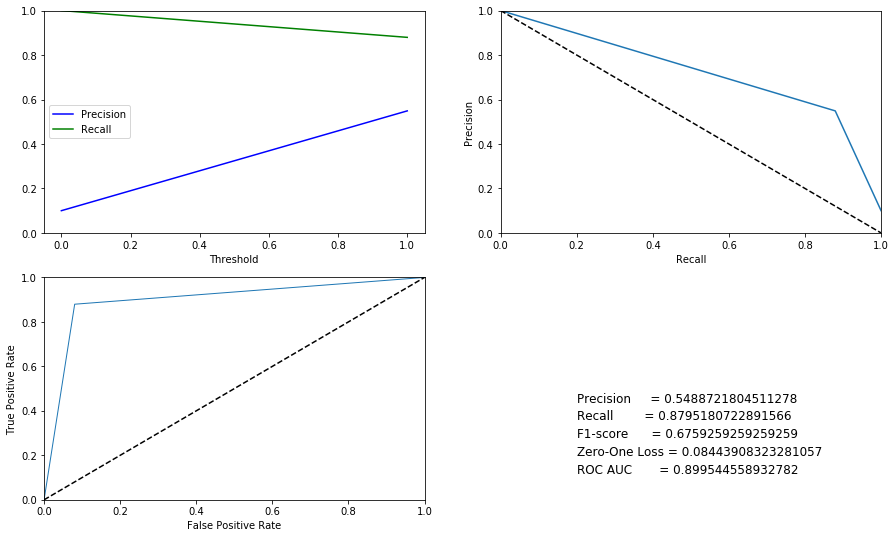

In [130]:
precision, recall, f1, zeroone, auc = evaluate_model(ridge_clf,X_test, y_test)

In [144]:
results.loc[len(results)] = ['RidgeClassifier',precision, recall, f1, zeroone, auc]

In [145]:
results

,Model,Precision,Recall,F1-score,Zero-One Loss,ROC AUC
0,RidgeClassifier,0.548872,0.879518,0.675926,0.084439,0.899545


## SGD Classifier

In [201]:
%%time

parm, f1_scores = [], []
#for _parm in tqdm_notebook(np.arange(0.01,0.1,0.04)):
for _parm in tqdm_notebook(['constant','optimal','invscaling','adaptive']):
    _clf = SGDClassifier(max_iter=1000, tol=1e-4, learning_rate=_parm, eta0=0.09, class_weight='balanced', random_state=42).fit(X_train,y_train)
    y_pred = _clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"eta0 = {_parm} \t F1-score = {f1}")
    parm.append(_parm)
    f1_scores.append(f1)
best = f1_scores.index(max(f1_scores))
print(f"BEST RESULTS: Parm = {parm[best]} \t F1-score = {f1_scores[best]}")

eta0 = constant 	 F1-score = 0.6161616161616162
eta0 = optimal 	 F1-score = 0.6224489795918368
eta0 = invscaling 	 F1-score = 0.6930693069306931
eta0 = adaptive 	 F1-score = 0.6503067484662576

BEST RESULTS: Parm = invscaling 	 F1-score = 0.6930693069306931
Wall time: 15.2 s


In [204]:
# Refit with the best parameter
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-4, learning_rate='invscaling', \
                        eta0=0.09, class_weight='balanced', random_state=42).fit(X_train,y_train)

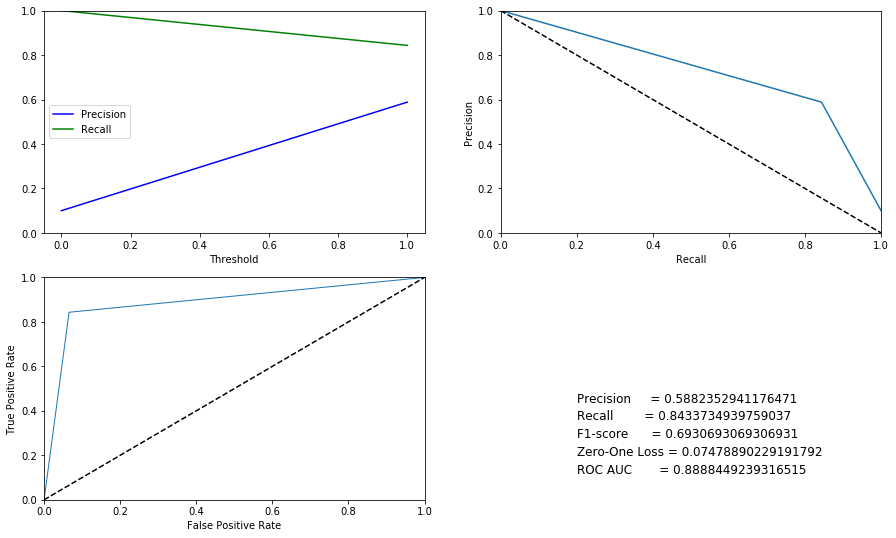

In [206]:
precision, recall, f1, zeroone, auc = evaluate_model(sgd_clf,X_test, y_test)

In [207]:
results.loc[len(results)] = ['SGDClassifier',precision, recall, f1, zeroone, auc]

# Bayes Models

In [208]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB

## BernoulliNB

Parm = 1.400 	 F1-score = 0.59813
Parm = 1.410 	 F1-score = 0.59813
Parm = 1.420 	 F1-score = 0.59813
Parm = 1.430 	 F1-score = 0.60094
Parm = 1.440 	 F1-score = 0.60094
Parm = 1.450 	 F1-score = 0.60377
Parm = 1.460 	 F1-score = 0.60377
Parm = 1.470 	 F1-score = 0.60377
Parm = 1.480 	 F1-score = 0.60377
Parm = 1.490 	 F1-score = 0.60377
Parm = 1.500 	 F1-score = 0.60377
Parm = 1.510 	 F1-score = 0.60377
Parm = 1.520 	 F1-score = 0.60377
Parm = 1.530 	 F1-score = 0.59716
Parm = 1.540 	 F1-score = 0.59048
Parm = 1.550 	 F1-score = 0.59048
Parm = 1.560 	 F1-score = 0.59048
Parm = 1.570 	 F1-score = 0.59048
Parm = 1.580 	 F1-score = 0.59048
Parm = 1.590 	 F1-score = 0.59048
Parm = 1.600 	 F1-score = 0.58768
Parm = 1.610 	 F1-score = 0.58768

BEST RESULTS: Parm = 1.45 	 F1-score = 0.6037735849056604
Wall time: 4.74 s


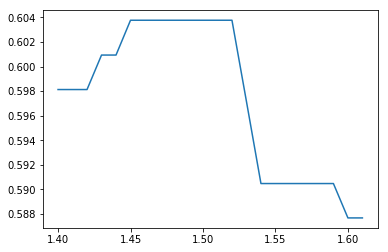

In [223]:
%%time

parm, f1_scores = [], []
for _parm in tqdm_notebook(np.arange(1.4,1.61,0.01)):
#for _parm in tqdm_notebook([True,False]):
    _clf = BernoulliNB(alpha=_parm).fit(X_train,y_train)
    y_pred = _clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"Parm = {_parm:4.3f} \t F1-score = {f1:.5f}")
    parm.append(_parm)
    f1_scores.append(f1)
best = f1_scores.index(max(f1_scores))
print(f"BEST RESULTS: Parm = {parm[best]} \t F1-score = {f1_scores[best]}")

plt.plot(parm,f1_scores)

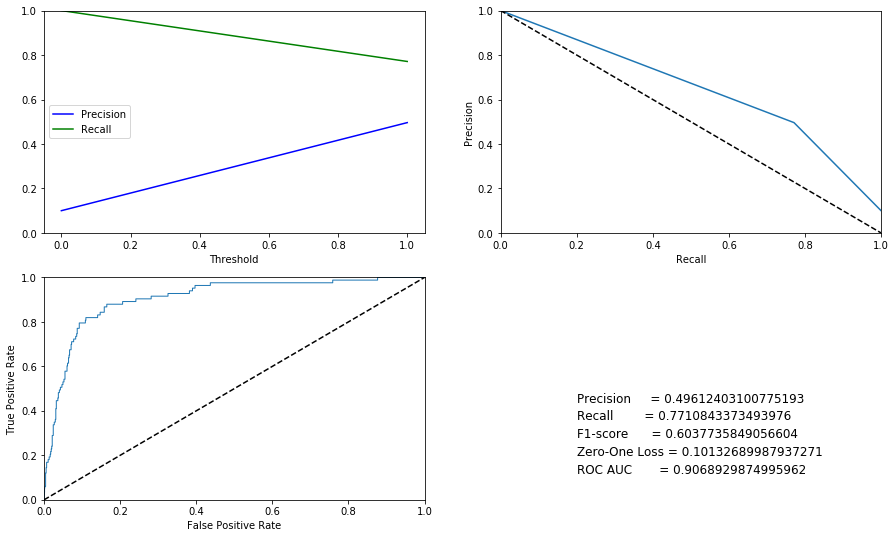

In [224]:
bern_clf = BernoulliNB(alpha=1.5).fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(bern_clf,X_test, y_test)
results.loc[len(results)] = ['BernoulliNB',precision, recall, f1, zeroone, auc]

## MultinomialNB

Parm = 0.800 	 F1-score = 0.60577
Parm = 0.810 	 F1-score = 0.60577
Parm = 0.820 	 F1-score = 0.60577
Parm = 0.830 	 F1-score = 0.60577
Parm = 0.840 	 F1-score = 0.60577
Parm = 0.850 	 F1-score = 0.60577
Parm = 0.860 	 F1-score = 0.60577
Parm = 0.870 	 F1-score = 0.60577
Parm = 0.880 	 F1-score = 0.61244
Parm = 0.890 	 F1-score = 0.61244
Parm = 0.900 	 F1-score = 0.61244
Parm = 0.910 	 F1-score = 0.61244
Parm = 0.920 	 F1-score = 0.60952
Parm = 0.930 	 F1-score = 0.60952
Parm = 0.940 	 F1-score = 0.60952
Parm = 0.950 	 F1-score = 0.60952
Parm = 0.960 	 F1-score = 0.60952
Parm = 0.970 	 F1-score = 0.60952
Parm = 0.980 	 F1-score = 0.60952
Parm = 0.990 	 F1-score = 0.60952

BEST RESULTS: Parm = 0.880 	 F1-score = 0.61244
Wall time: 2.48 s


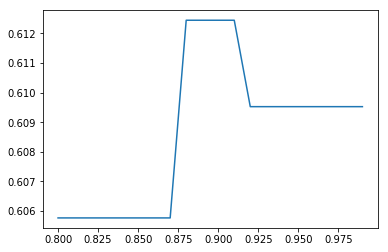

In [227]:
%%time

parm, f1_scores = [], []
for _parm in tqdm_notebook(np.arange(0.8,1.0,0.01)):
#for _parm in tqdm_notebook([True,False]):
    _clf = MultinomialNB(alpha=_parm).fit(X_train,y_train)
    y_pred = _clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"Parm = {_parm:4.3f} \t F1-score = {f1:.5f}")
    parm.append(_parm)
    f1_scores.append(f1)
best = f1_scores.index(max(f1_scores))
print(f"BEST RESULTS: Parm = {parm[best]:4.3f} \t F1-score = {f1_scores[best]:.5f}")

plt.plot(parm,f1_scores)

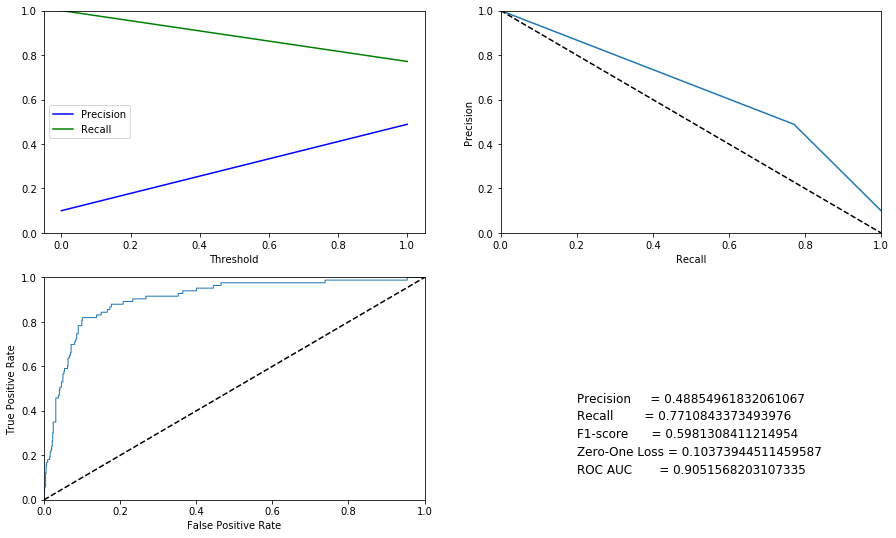

In [229]:
multNB_clf = BernoulliNB(alpha=0.9).fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(multNB_clf,X_test, y_test)
results.loc[len(results)] = ['MultinomialNB',precision, recall, f1, zeroone, auc]

## ComplementNB

Parm = 0.800 	 F1-score = 0.60577
Parm = 0.810 	 F1-score = 0.60577
Parm = 0.820 	 F1-score = 0.60577
Parm = 0.830 	 F1-score = 0.60577
Parm = 0.840 	 F1-score = 0.60577
Parm = 0.850 	 F1-score = 0.60577
Parm = 0.860 	 F1-score = 0.60577
Parm = 0.870 	 F1-score = 0.60577
Parm = 0.880 	 F1-score = 0.61244
Parm = 0.890 	 F1-score = 0.61244
Parm = 0.900 	 F1-score = 0.61244
Parm = 0.910 	 F1-score = 0.61244
Parm = 0.920 	 F1-score = 0.60952
Parm = 0.930 	 F1-score = 0.60952
Parm = 0.940 	 F1-score = 0.60952
Parm = 0.950 	 F1-score = 0.60952
Parm = 0.960 	 F1-score = 0.60952
Parm = 0.970 	 F1-score = 0.60952
Parm = 0.980 	 F1-score = 0.60952
Parm = 0.990 	 F1-score = 0.60952

BEST RESULTS: Parm = 0.880 	 F1-score = 0.61244
Wall time: 2.41 s


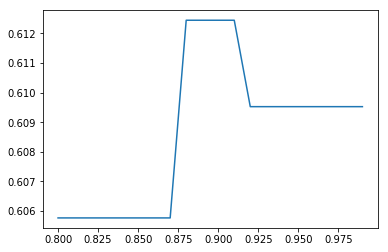

In [236]:
%%time

parm, f1_scores = [], []
for _parm in tqdm_notebook(np.arange(0.8,1.0,0.01)):
#for _parm in tqdm_notebook([True,False]):
    _clf = MultinomialNB(alpha=_parm).fit(X_train,y_train)
    y_pred = _clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"Parm = {_parm:4.3f} \t F1-score = {f1:.5f}")
    parm.append(_parm)
    f1_scores.append(f1)
best = f1_scores.index(max(f1_scores))
print(f"BEST RESULTS: Parm = {parm[best]:4.3f} \t F1-score = {f1_scores[best]:.5f}")

plt.plot(parm,f1_scores)

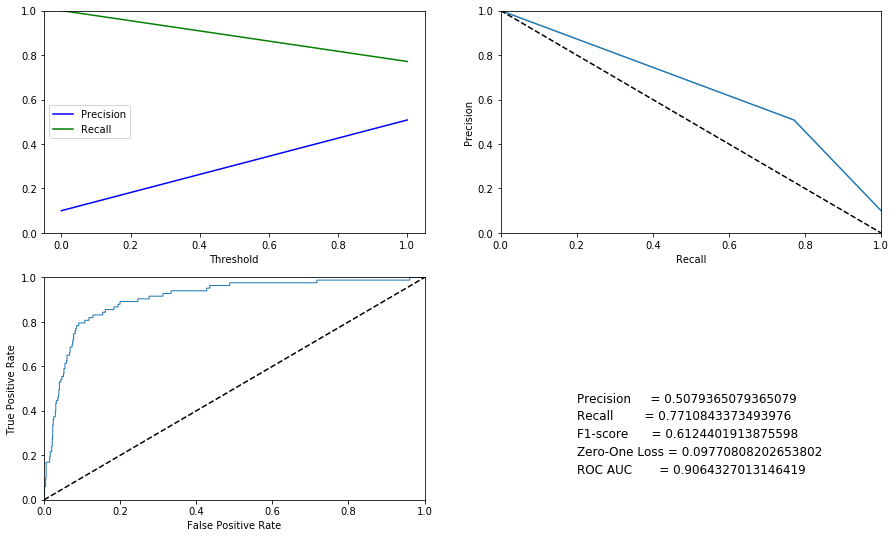

In [237]:
_clf = MultinomialNB(alpha=0.9).fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(_clf,X_test, y_test)
results.loc[len(results)] = ['MultinomialNB',precision, recall, f1, zeroone, auc]

# Nearest Neighbor models

In [239]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

## K-NN

Parm = 5.000 	 F1-score = 0.67
Parm = 10.000 	 F1-score = 0.67
Parm = 20.000 	 F1-score = 0.67
Parm = 30.000 	 F1-score = 0.67
Parm = 40.000 	 F1-score = 0.67
BEST RESULTS: Parm = 5.000 	 F1-score = 0.67105
Wall time: 2min 28s


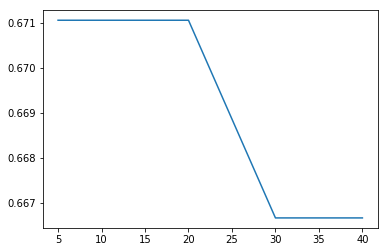

In [252]:
%%time

parm, f1_scores = [], []
#for _parm in tqdm_notebook(np.arange(0.8,1.0,0.01)):
for _parm in tqdm_notebook([5,10,20,30,40]):
    _clf = KNeighborsClassifier(leaf_size=_parm).fit(X_train,y_train)
    y_pred = _clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    if isinstance(_parm, str):
        print(f"Parm = {_parm} \t F1-score = {f1:.2f}")
    else:
        print(f"Parm = {_parm:4.3f} \t F1-score = {f1:.2f}")
    parm.append(_parm)
    f1_scores.append(f1)
best = f1_scores.index(max(f1_scores))

if isinstance(_parm, str):
    print(f"BEST RESULTS: Parm = {parm[best]} \t F1-score = {f1_scores[best]:.5f}")
else:
    print(f"BEST RESULTS: Parm = {parm[best]:4.3f} \t F1-score = {f1_scores[best]:.5f}")

plt.plot(parm,f1_scores)

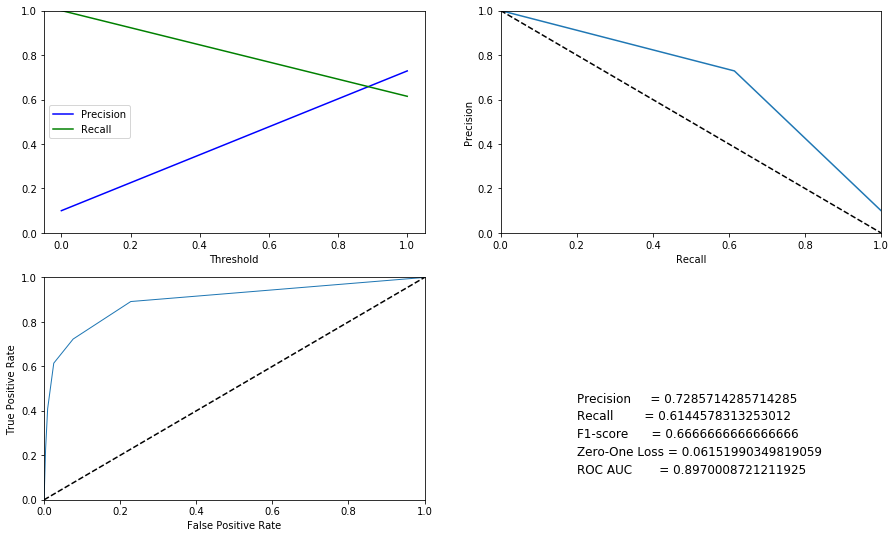

In [253]:
_clf = KNeighborsClassifier().fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(_clf,X_test, y_test)
results.loc[len(results)] = ['KNeighborsClassifier',precision, recall, f1, zeroone, auc]

## Radius-NN

In [256]:
_clf = RadiusNeighborsClassifier(radius=5.0).fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(_clf,X_test, y_test)
#results.loc[len(results)] = ['KNeighborsClassifier',precision, recall, f1, zeroone, auc]

ValueError: No neighbors found for test samples [0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 39, 41, 42, 43, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 64, 65, 67, 68, 69, 70, 71, 72, 73, 75, 77, 78, 79, 80, 81, 83, 84, 85, 87, 88, 89, 90, 93, 94, 96, 97, 98, 99, 100, 101, 104, 105, 107, 114, 116, 118, 119, 120, 121, 122, 125, 126, 127, 128, 130, 132, 133, 134, 136, 137, 138, 140, 141, 144, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 165, 167, 169, 170, 171, 172, 174, 175, 177, 178, 179, 180, 183, 184, 185, 186, 187, 188, 190, 191, 194, 195, 197, 199, 200, 201, 203, 204, 205, 206, 208, 209, 210, 212, 216, 217, 219, 220, 222, 225, 229, 232, 234, 235, 236, 237, 238, 240, 241, 242, 243, 244, 245, 247, 248, 250, 253, 255, 256, 257, 258, 260, 261, 262, 263, 264, 266, 267, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 283, 284, 285, 287, 288, 290, 292, 293, 294, 295, 296, 298, 299, 301, 302, 304, 305, 306, 308, 310, 311, 312, 314, 315, 316, 318, 319, 321, 323, 324, 326, 327, 328, 329, 330, 333, 334, 335, 336, 337, 338, 340, 341, 342, 343, 344, 345, 346, 347, 349, 352, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 369, 370, 371, 372, 373, 374, 375, 376, 378, 379, 380, 381, 383, 384, 385, 386, 387, 390, 395, 396, 397, 398, 400, 401, 404, 405, 406, 408, 410, 412, 414, 415, 416, 417, 418, 419, 420, 421, 423, 424, 428, 433, 435, 438, 441, 442, 443, 445, 446, 449, 450, 451, 452, 453, 455, 456, 458, 459, 460, 462, 463, 465, 466, 467, 468, 470, 471, 473, 474, 475, 476, 477, 479, 480, 481, 482, 484, 486, 488, 490, 491, 492, 493, 494, 495, 496, 497, 501, 502, 504, 505, 506, 508, 509, 511, 513, 514, 515, 516, 517, 518, 519, 520, 521, 523, 524, 527, 528, 529, 530, 531, 533, 534, 535, 536, 537, 544, 549, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 568, 569, 572, 573, 574, 575, 577, 578, 580, 582, 583, 584, 586, 588, 590, 594, 595, 596, 597, 598, 599, 601, 602, 603, 604, 605, 606, 607, 609, 612, 614, 616, 617, 619, 620, 622, 624, 625, 626, 628, 629, 630, 631, 633, 634, 638, 640, 641, 643, 644, 645, 647, 655, 656, 657, 659, 660, 662, 663, 664, 665, 668, 669, 670, 673, 675, 676, 677, 681, 684, 685, 686, 687, 689, 691, 693, 694, 696, 698, 702, 703, 704, 706, 708, 709, 711, 712, 713, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 730, 732, 733, 734, 735, 738, 743, 744, 745, 747, 748, 749, 750, 751, 752, 753, 755, 757, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 778, 779, 780, 782, 783, 785, 786, 788, 790, 791, 792, 793, 796, 797, 798, 800, 801, 802, 804, 806, 807, 809, 811, 812, 813, 814, 815, 818, 819, 820, 821, 823, 824, 825, 826, 828], you can try using larger radius, give a label for outliers, or consider removing them from your dataset.

(Cannot find neighbors for the test set.)

# Ensemble Models

In [257]:
from sklearn.ensemble import RandomForestClassifier, \
                             AdaBoostClassifier, \
                             GradientBoostingClassifier, \
                             BaggingClassifier, \
                             VotingClassifier

## AdaBoost

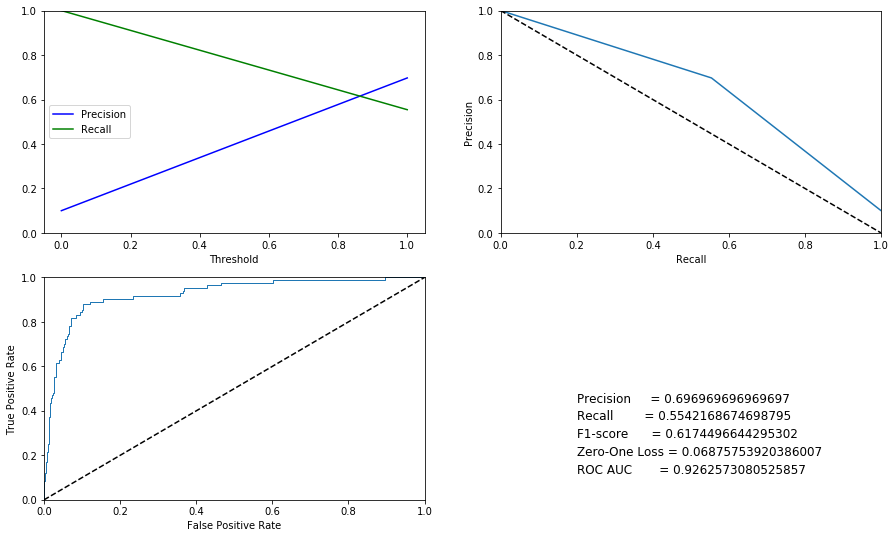

In [262]:
_clf = AdaBoostClassifier(n_estimators=200, random_state=42).fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(_clf,X_test, y_test)
results.loc[len(results)] = ['AdaBoostClassifier',precision, recall, f1, zeroone, auc]

## GradientBoostingClassifier

Wall time: 2min 36s


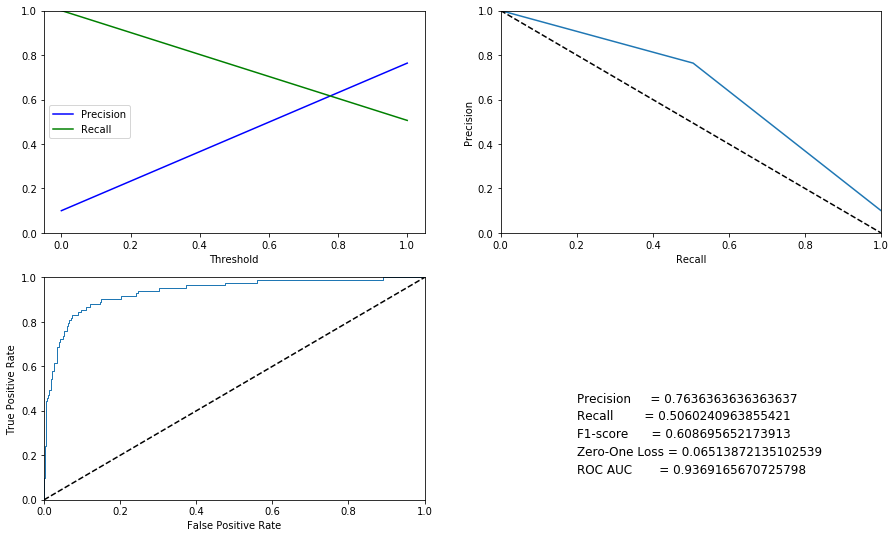

In [266]:
%%time
_clf = GradientBoostingClassifier(n_estimators=250, random_state=42).fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(_clf,X_test, y_test)
#results.loc[len(results)] = ['GradientBoostingClassifier',precision, recall, f1, zeroone, auc]

## BaggingClassifier

Wall time: 7min 48s


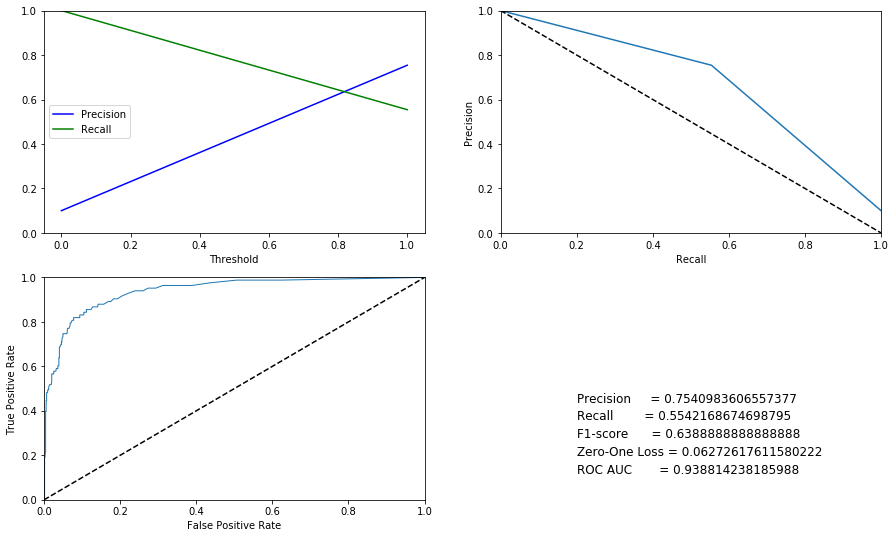

In [267]:
%%time
_clf = BaggingClassifier(n_estimators=250, random_state=42).fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(_clf,X_test, y_test)
results.loc[len(results)] = ['BaggingClassifier',precision, recall, f1, zeroone, auc]

## RandomForestClassifier

Wall time: 16.9 s


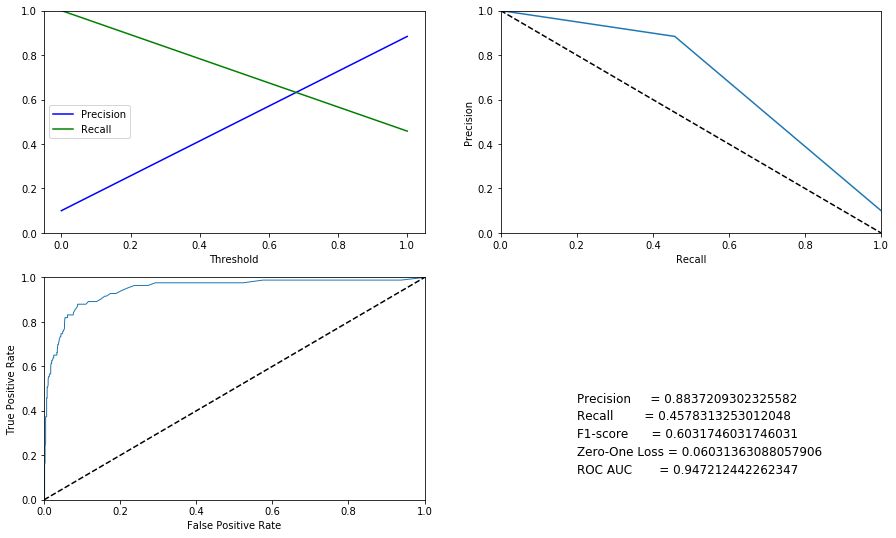

In [268]:
%%time
_clf = RandomForestClassifier(n_estimators=250, random_state=42).fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(_clf,X_test, y_test)
results.loc[len(results)] = ['RandomForestClassifier',precision, recall, f1, zeroone, auc]

Wall time: 6min 31s


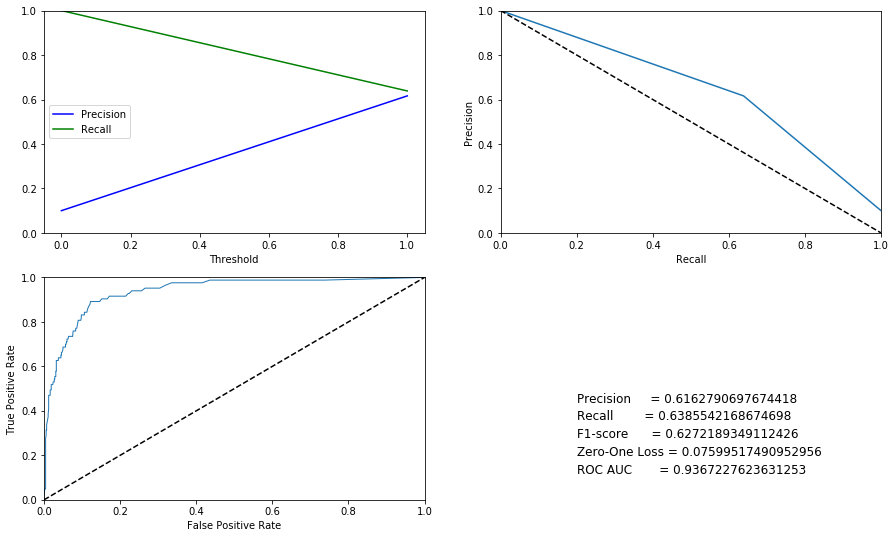

In [365]:
%%time
_clf = RandomForestClassifier(n_estimators=250, 
                              random_state=42,
                              max_features=None,
                              class_weight='balanced_subsample').fit(X_train,y_train)
precision, recall, f1, zeroone, auc  = evaluate_model(_clf,X_test, y_test)
#results.loc[len(results)] = ['RandomForestClassifier',precision, recall, f1, zeroone, auc]

In [366]:
results.loc[len(results)] = ['RandomForestClassifier (opt)',precision, recall, f1, zeroone, auc]

## VotingClassifier

Wall time: 20.3 s


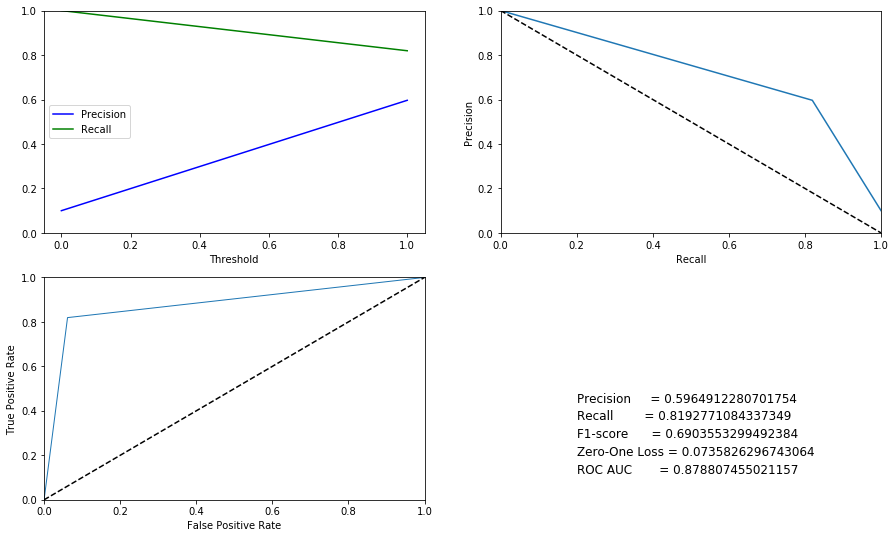

In [300]:
%%time
ridge = RidgeClassifier(alpha=60, class_weight='balanced')
sgd   = SGDClassifier(max_iter=1000, tol=1e-4, learning_rate='invscaling', \
                        eta0=0.09, class_weight='balanced')
rnd_f = RandomForestClassifier(n_estimators=250)
estimators = [('Ridge',ridge),('SGD',sgd),('Rnd_for',rnd_f)]
_clf = VotingClassifier(estimators=estimators,voting='hard',weights=[2,2,1], n_jobs=4).fit(X_train,y_train)
precision, recall, f1, zeroone, auc = evaluate_model(_clf,X_test, y_test)

In [ ]:
#%%time

parm, f1_scores = [], []

# Estimators
ridge = RidgeClassifier(alpha=60, class_weight='balanced')
sgd   = SGDClassifier(max_iter=1000, tol=1e-4, learning_rate='invscaling', \
                        eta0=0.09, class_weight='balanced')
rnd_f = RandomForestClassifier(n_estimators=250)

estimators = [('Ridge',ridge),('SGD',sgd),('Rnd_for',rnd_f)]

w1 = [1,1,1]
w2 = [3,2,1]
w3 = [2,3,1]
w4 = [1,1,2]
w5 = [1,1,5]
w6 = [4,4,1]

#for _parm in tqdm_notebook(np.arange(0.8,1.0,0.01)):
for _parm in tqdm_notebook([None,w1]):
    _clf = VotingClassifier(estimators=estimators,voting='hard',weights=_parm, n_jobs=4).fit(X_train,y_train)
    y_pred = _clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    if isinstance(_parm, str):
        print(f"Parm = {_parm} \t F1-score = {f1:.2f}")
    else:
        print(f"Parm = {_parm} \t F1-score = {f1:.2f}")
    parm.append(_parm)
    f1_scores.append(f1)
best = f1_scores.index(max(f1_scores))

if isinstance(_parm, str):
    print(f"BEST RESULTS: Parm = {parm[best]} \t F1-score = {f1_scores[best]:.5f}")
else:
    print(f"BEST RESULTS: Parm = {parm[best]} \t F1-score = {f1_scores[best]:.5f}")

plt.plot(parm,f1_scores)

Wall time: 49.8 s


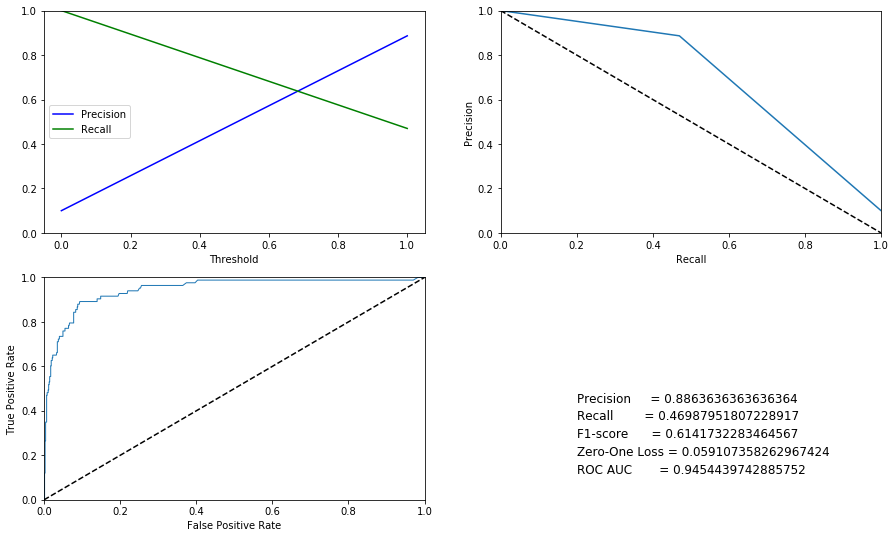

In [310]:
%%time
ridge = RidgeClassifier(alpha=60, class_weight='balanced')
sgd   = SGDClassifier(max_iter=1000, tol=1e-4, learning_rate='invscaling', \
                        eta0=0.09, class_weight='balanced')

rnd_1 = RandomForestClassifier(n_estimators=250, random_state=10)
rnd_2 = RandomForestClassifier(n_estimators=250, random_state=20)
rnd_3 = RandomForestClassifier(n_estimators=250, random_state=30)
rnd_4 = RandomForestClassifier(n_estimators=250, random_state=40)
rnd_5 = RandomForestClassifier(n_estimators=250, random_state=50)

# ('Ridge',ridge),('SGD',sgd),
estimators = [('Rnd_1',rnd_1),('Rnd_2',rnd_2),('Rnd_3',rnd_3),('Rnd_4',rnd_4),('Rnd_5',rnd_5)]
_clf = VotingClassifier(estimators=estimators,voting='soft', n_jobs=4).fit(X_train,y_train)
precision, recall, f1, zeroone, auc = evaluate_model(_clf,X_test, y_test)
results.loc[len(results)] = ['VotingClassifier, (5*RF)',precision, recall, f1, zeroone, auc]

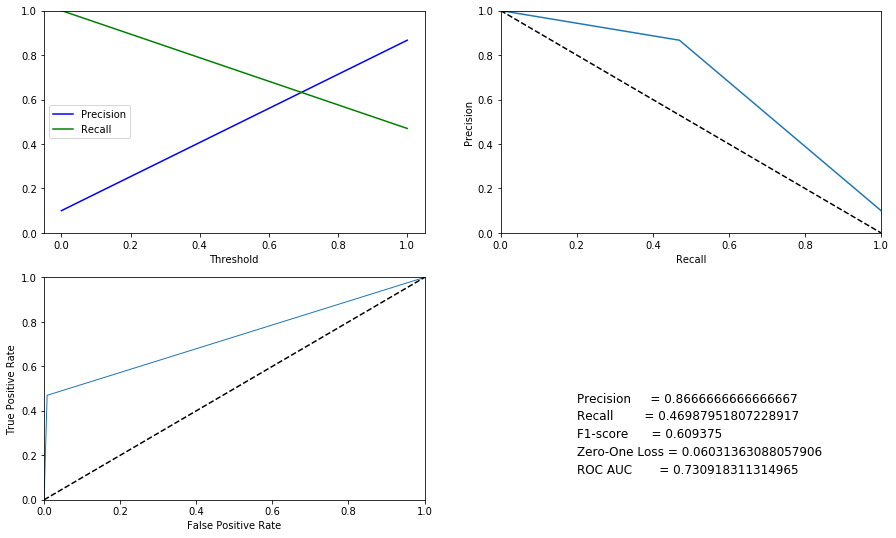

In [334]:
# ('SGD',sgd),

# Using voting='hard' because RidgeClassifier does not have predict_proba
estimators = [('Ridge',ridge),('Rnd_1',rnd_1),('Rnd_2',rnd_2),('Rnd_3',rnd_3),('Rnd_4',rnd_4)]
_clf = VotingClassifier(estimators=estimators,voting='hard', n_jobs=4).fit(X_train,y_train)
precision, recall, f1, zeroone, auc = evaluate_model(_clf,X_test, y_test)
results.loc[len(results)] = ['VotingClassifier, (1*Ridge, 4*RF)',precision, recall, f1, zeroone, auc]

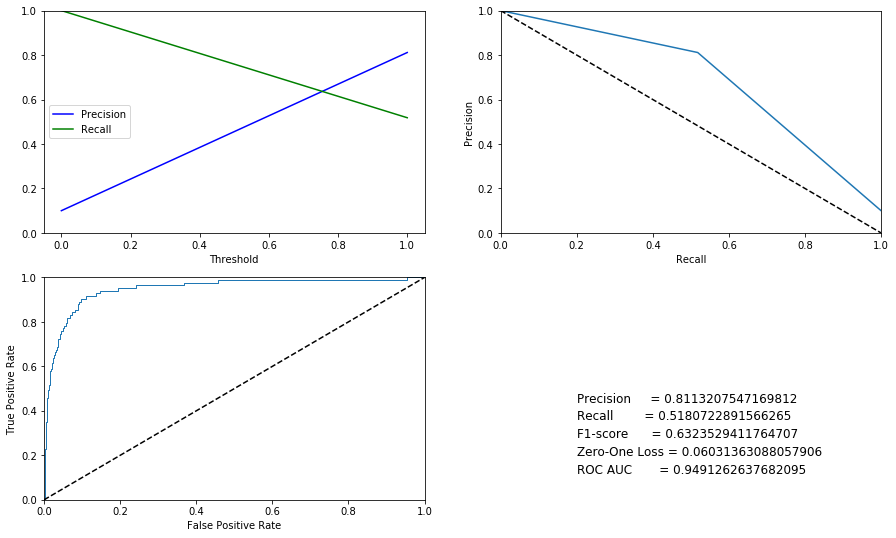

In [335]:
# ('Ridge',ridge),
sgd   = SGDClassifier(max_iter=1000, tol=1e-4, loss='log', learning_rate='invscaling', \
                        eta0=0.09, class_weight='balanced')
# Using voting='hard' because RidgeClassifier does not have predict_proba
estimators = [('SGD',sgd),('Rnd_1',rnd_1),('Rnd_2',rnd_2),('Rnd_3',rnd_3),('Rnd_4',rnd_4)]
_clf = VotingClassifier(estimators=estimators,voting='soft', n_jobs=4).fit(X_train,y_train)
precision, recall, f1, zeroone, auc = evaluate_model(_clf,X_test, y_test)
results.loc[len(results)] = ['VotingClassifier, (1*SGD, 4*RF)',precision, recall, f1, zeroone, auc]

## AverageRandomForest

In [363]:
# The averaged random forest model
%load_ext autoreload
%autoreload 2
from AverageRandomForests import AverageRandomForestClassifier

In [373]:
_clf = AverageRandomForestClassifier(n_forests=5, 
                                      n_estimators=250,
                                      class_weight='balanced_subsample',
                                      verbose=0, n_jobs=4)

SPLIT: 0 [TRAIN: 5968 ,	TEST: 1493 ] 	Time: 4.485631704330444  seconds.
Confusion Matrix = 
 [[1322   21]
 [  89   61]]
	  Precision =  0.7439024390243902
	  Recall    =  0.4066666666666667
	  F1-score  =  0.5258620689655172
	  Score     =  0.9263228399196249
	  ROC AUC   =  0.9307421196326632 

SPLIT: 1 [TRAIN: 5969 ,	TEST: 1492 ] 	Time: 4.486768960952759  seconds.
Confusion Matrix = 
 [[1320   23]
 [  74   75]]
	  Precision =  0.7653061224489796
	  Recall    =  0.5033557046979866
	  F1-score  =  0.6072874493927125
	  Score     =  0.9349865951742627
	  ROC AUC   =  0.9464686392779863 

SPLIT: 2 [TRAIN: 5969 ,	TEST: 1492 ] 	Time: 4.286019802093506  seconds.
Confusion Matrix = 
 [[1323   20]
 [  80   69]]
	  Precision =  0.7752808988764045
	  Recall    =  0.46308724832214765
	  F1-score  =  0.5798319327731092
	  Score     =  0.9329758713136729
	  ROC AUC   =  0.945436691370117 

SPLIT: 3 [TRAIN: 5969 ,	TEST: 1492 ] 	Time: 4.279958486557007  seconds.
Confusion Matrix = 
 [[1321   22]
 [ 

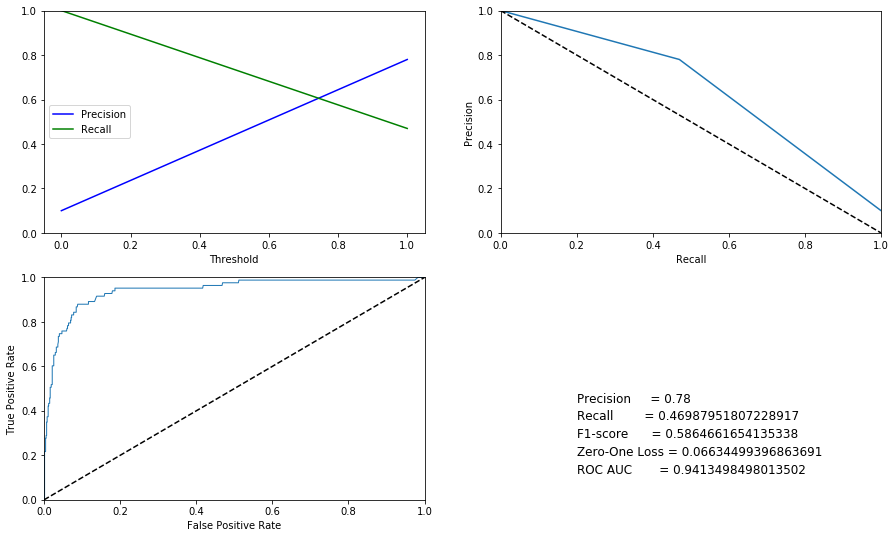

In [374]:
_clf.fit(X_train,y_train)
precision, recall, f1, zeroone, auc = evaluate_model(_clf,X_test, y_test)
results.loc[len(results)] = ['AverageRandomForestClassifier',precision, recall, f1, zeroone, auc]

# Results

In [375]:
results

,Model,Precision,Recall,F1-score,Zero-One Loss,ROC AUC
0,RidgeClassifier,0.548872,0.879518,0.675926,0.084439,0.899545
1,SGDClassifier,0.588235,0.843373,0.693069,0.074789,0.888845
2,BernoulliNB,0.496124,0.771084,0.603774,0.101327,0.906893
3,MultinomialNB,0.488550,0.771084,0.598131,0.103739,0.905157
4,MultinomialNB,0.507937,0.771084,0.612440,0.097708,0.906433
5,KNeighborsClassifier,0.728571,0.614458,0.666667,0.061520,0.897001
6,AdaBoostClassifier,0.696970,0.554217,0.617450,0.068758,0.926257
7,GradientBoostingClassifier,0.763636,0.506024,0.608696,0.065139,0.936917
8,BaggingClassifier,0.754098,0.554217,0.638889,0.062726,0.938814
9,RandomForestClassifier,0.883721,0.457831,0.603175,0.060314,0.947212


(0, 1)

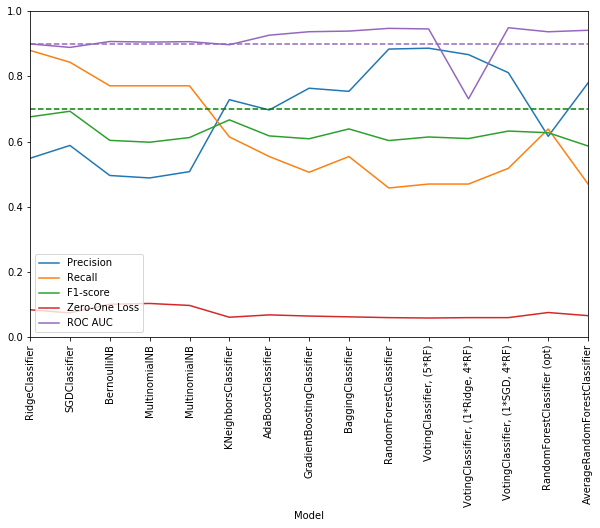

In [376]:
results.plot(x='Model',y=['Precision', 'Recall','F1-score','Zero-One Loss', 'ROC AUC'], rot=90, figsize=(10,6))
plt.xticks(results.index, results['Model'])
plt.plot(([0.7] * len(results['Model'])), 'g--')
plt.plot(([0.9] * len(results['Model'])), 'C4--')
plt.ylim([0,1])